In [1]:
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision import transforms
import numpy as np
import os
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from facenet_pytorch import InceptionResnetV1
from torch import optim
from facenet_pytorch import fixed_image_standardization, training
from torch.utils.data import DataLoader

In [2]:
class CustomImageDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=ToTensor()):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dira (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        # image = image.view((224,224,3))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # image = cv2.equalizeHist(image)
        image = Image.fromarray(image)
        # print(type(image))
        # # image = np.transpose(image,(1,2,0)) 
        label = self.landmarks_frame.iloc[idx, 1]
        label = np.array(label)
        if self.transform:
            image = self.transform(image)
        return image,label

In [20]:
from facenet_pytorch import fixed_image_standardization, training
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    fixed_image_standardization
])

trainset = CustomImageDataset(csv_file = 'train_new.csv',
                              root_dir='crop-mask-aug/train/',
                             transform = preprocessing)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0 torch.Size([3, 224, 224])
1 torch.Size([3, 224, 224])
2 torch.Size([3, 224, 224])
3 torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


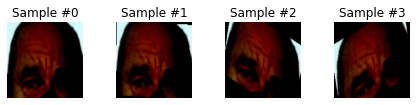

In [21]:
for i in range(len(trainset)):
    data,label = trainset[i]

    print(i, data.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(data.permute(1,2,0),cmap = plt.cm.gray)
    if i == 3:
        plt.show()
        break

In [22]:
from torch.utils.data import DataLoader
trainloader = DataLoader(trainset, batch_size=8,
                        shuffle=True, num_workers=0)

In [23]:
testset = CustomImageDataset(csv_file = 'test.csv',
                              root_dir='crop-mask-face/test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=8,
                        shuffle=True, num_workers=0)
valset = CustomImageDataset(csv_file = 'val.csv',
                              root_dir='crop-mask-face/val/',
                             transform = preprocessing)
valloader = DataLoader(valset, batch_size=8,
                        shuffle=True, num_workers=0)

In [24]:
from torchvision.models import resnet50
# model_ft = resnet50(pretrained = True, progress = True)

In [25]:
model= resnet50(pretrained = True, progress = True)

In [30]:
from torch import nn

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.fc = nn.Linear(2048, 50)
        # self.softmax = torch.nn.Softmax(dim = 1)
    
    def forward(self, x):
        x = self.fc(x)
        return x
model.fc = net()

In [31]:
from torch import optim
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
for child in model.children():
    if child != model.fc:
        for param in child.parameters():
            param.requires_grad = False
    if child == model.fc:
        for param in child.parameters():
            param.requires_grad = True
model.to(device)       
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

Using cuda device


In [33]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   100] loss: 3.055
[1,   200] loss: 2.849
[1,   300] loss: 2.744
[1,   400] loss: 2.648
[1,   500] loss: 2.529
[1,   600] loss: 2.380
[2,   100] loss: 2.242
[2,   200] loss: 2.008
[2,   300] loss: 2.141
[2,   400] loss: 2.001
[2,   500] loss: 1.980
[2,   600] loss: 1.898
Finished Training


In [1]:
for child in model.children():
    for param in child.parameters():
        param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=0.001, momentum = 0.9)

NameError: name 'model' is not defined

In [2]:
#define where to record train loss, valid loss and valid accuracy of each epoch
train_loss = []
valid_loss = []
valid_acc = []
min_val_loss = 1e10
#imporve the batch size
for epoch in range(50):  # loop over the dataset multiple times

    train_running_loss = 0.0
    valid_running_loss = 0.0
    valid_rc = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_running_loss += loss.item()
        if i % 100 == 99:    # print every 1000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] finished!')
            
    #save the model with smallest loss on validation set
    for i, data in enumerate(valloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs)
        _,predicted = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # statistics
        valid_running_loss += loss.item()
        valid_rc += (predicted == labels).sum().item()
    train_loss.append(train_running_loss / len(trainloader))
    valid_loss.append(valid_running_loss/len(valloader))
    #compare validation loss, save the parameters corresponds to the minmimum valid loss epoch
    if valid_loss[-1]<min_val_loss:
        torch.save(model.state_dict(),'model_parameter.pth')
        min_val_loss = valid_loss[-1]
    valid_acc.append(valid_rc/len(valset))
    #print out train loss and validation loss and accuracy of each epoch
    print(f'Epoch: {epoch + 1}, Train Loss: {train_running_loss / len(trainloader):.3f}')
    print(f'Epoch: {epoch + 1}, Validation Loss: {valid_running_loss / len(valloader):.3f}, Validation Accuracy: {valid_rc/len(valset):.2f}')
    train_running_loss = 0.0
    valid_running_lossa = 0.0
    valid_rc = 0

print('Finished Training')

NameError: name 'trainloader' is not defined

In [42]:
model.eval()
correct = 0
total = 0
sample_count = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         print(labels)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _,predicted  = torch.max(outputs, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if 0 in (predicted == labels):
            determinant = predicted == labels
            for j in range(len(determinant)):
                if determinant[j] == False:
                    print(f'False Sample {sample_count+1}: True Labels: {labels[j].item()}, Predicted:{predicted[j].item()}')
                    sample_count += 1
                    # plt.imshow(images[j].cpu().permute(1,2,0))

print(f'Accuracy of the network on the 196 test images: {100 * correct // total} %')

False Sample 1: True Labels: 47, Predicted:32
False Sample 2: True Labels: 2, Predicted:41
False Sample 3: True Labels: 13, Predicted:45
False Sample 4: True Labels: 23, Predicted:3
False Sample 5: True Labels: 37, Predicted:34
False Sample 6: True Labels: 30, Predicted:13
False Sample 7: True Labels: 46, Predicted:40
False Sample 8: True Labels: 4, Predicted:45
False Sample 9: True Labels: 37, Predicted:13
Accuracy of the network on the 196 test images: 95 %


In [43]:
torch.save(model.state_dict(),'model_parameter_unES.pth')

In [45]:
model.eval().load_state_dict(torch.load('./savedmodels/smodel_parameter.pth'), strict=True)
correct = 0
total = 0
sample_count = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for i,data in enumerate(testloader):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
#         print(labels)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _,predicted  = torch.max(outputs, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if 0 in (predicted == labels):
            determinant = predicted == labels
            for j in range(len(determinant)):
                if determinant[j] == False:
                    print(f'False Sample {sample_count+1}: True Labels: {labels[j].item()}, Predicted:{predicted[j].item()}')
                    sample_count += 1
                    # plt.imshow(images[j].cpu().permute(1,2,0))

print(f'Accuracy of the network on the 196 test images: {100 * correct // total} %')

False Sample 1: True Labels: 47, Predicted:1
False Sample 2: True Labels: 9, Predicted:2
False Sample 3: True Labels: 23, Predicted:34
False Sample 4: True Labels: 23, Predicted:48
False Sample 5: True Labels: 13, Predicted:21
False Sample 6: True Labels: 46, Predicted:40
False Sample 7: True Labels: 37, Predicted:39
False Sample 8: True Labels: 2, Predicted:23
False Sample 9: True Labels: 21, Predicted:3
False Sample 10: True Labels: 47, Predicted:20
False Sample 11: True Labels: 26, Predicted:3
False Sample 12: True Labels: 33, Predicted:30
False Sample 13: True Labels: 4, Predicted:34
False Sample 14: True Labels: 21, Predicted:43
Accuracy of the network on the 196 test images: 92 %


In [47]:
nb_classes = 50

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
acc_class = confusion_matrix.diag()/confusion_matrix.sum(1)

tensor([[5., 0., 0.,  ..., 0., 0., 0.],
        [0., 6., 0.,  ..., 0., 0., 0.],
        [0., 0., 2.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 2., 0., 0.],
        [0., 0., 0.,  ..., 0., 5., 0.],
        [0., 0., 0.,  ..., 0., 0., 3.]])


In [48]:
conf_m = pd.DataFrame(confusion_matrix)
conf_m.to_csv('confision_matrix2.csv')

In [49]:
cl = 0
bad_class  = []
for item in acc_class:
    if item < 0.5:
        bad_class.append(cl)
    cl += 1
print(bad_class)

[23]


In [51]:
testloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
right_pred_score = []
wrong_pred_score = []
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        ps = torch.exp(outputs)
        topk, topclass = ps.topk(1, dim=1)
        if i < 5:
            print("Prediction : ", topclass.cpu().numpy()[0][0], ", Score: ", topk.cpu().numpy()[0][0])
        if topclass.cpu().numpy()[0][0] == classes:
            right_pred_score.append(topk.cpu().numpy()[0][0])
        else:
            wrong_pred_score.append(topk.cpu().numpy()[0][0])

Prediction :  44 , Score:  2022.933
Prediction :  43 , Score:  445.9849
Prediction :  6 , Score:  12377140.0
Prediction :  27 , Score:  122513.76
Prediction :  30 , Score:  3.1453192


In [52]:
print(np.percentile(wrong_pred_score,80))
print(np.percentile(right_pred_score,15))

18.45269412994385
40.95219078063964


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  32 Prediction :  43 , Score:  2547.6934
True Label :  21 Prediction :  27 , Score:  171.47284


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  24 Prediction :  6 , Score:  189875.03
True Label :  38 Prediction :  43 , Score:  148.58409


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True Label :  46 Prediction :  40 , Score:  16.982067
True Label :  35 Prediction :  18 , Score:  308.4728


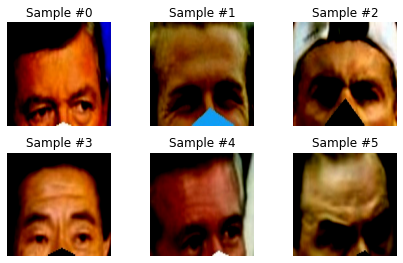

In [53]:
preprocessing = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    transforms.Resize((160,160)),
    fixed_image_standardization
])
testset = CustomImageDataset(csv_file = 'test.csv',
                              root_dir='crop-mask-face/test/',
                             transform = preprocessing)
testloader = DataLoader(testset, batch_size=1,
                        shuffle=True, num_workers=0)
sample = 0 
with torch.no_grad():
    for i, (inputs, classes) in enumerate(testloader):
        inputs = inputs.to(device)
        # print(inputs.shape)
        classes = classes.to(device)
        outputs = model(inputs)
        ps = torch.exp(outputs)
        topk, topclass = ps.topk(1, dim=1)
        if sample < 6:
            if classes[0].item() != topclass.cpu().numpy()[0][0]:
                print('True Label : ', classes[0].item(), "Prediction : ", topclass.cpu().numpy()[0][0], ", Score: ", topk.cpu().numpy()[0][0])
                ax = plt.subplot(2, 3, sample + 1)
                plt.tight_layout()
                ax.set_title('Sample #{}'.format(sample))
                ax.axis('off')
                plt.imshow(inputs[0].cpu().permute(1,2,0))
                sample += 1

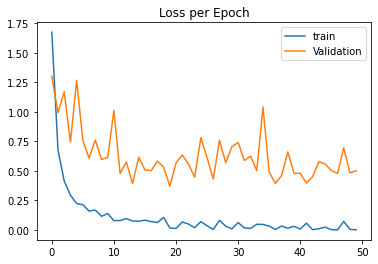

<Figure size 432x288 with 0 Axes>

In [66]:
plt.plot(train_loss,label = "train")
plt.plot(valid_loss,label="Validation")
plt.title("Loss per Epoch")
plt.legend()
plt.show()
plt.savefig('resnet50.png')